In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.linear_model import LinearRegression
import calendar

In [2]:
#Setting directory and read csv output from the GEE
belmontdir = "C:/Users/Nazia/Documents/OSU/Belmont/PlotData/"
doyNTL_allgrid3 = "allNTL_allgrid3_props.csv" 
df_allntl = pd.read_csv(belmontdir + doyNTL_allgrid3)

# Convert 'YYYY_MM_DD' column to datetime
df_allntl['YYYY_MM_DD'] = pd.to_datetime(df_allntl['YYYY_MM_DD'])

# Display the first few rows to verify the conversion
# print(df_allntl.head())

# Pivot the table
df_date = df_allntl.pivot(index='settl_pcod', columns='YYYY_MM_DD', values='NTLmean')

# Save the modified DataFrame to a CSV file
output_file = belmontdir + "allNTL_allgrid3_datetime.csv"
df_date.to_csv(output_file, index=True)  # Set index=True to include 'settl_pcod' in the CSV


In [3]:
# Next up is the cyclone track data
cyclone_track_gdf = gpd.read_file(belmontdir+"MadTrack_SegmentID_DATE.shp")
#print(cyclone_track_gdf.columns)
columns_to_keep = ['NAME', 'DATE', 'Segment_ID', 'NATURE']
onset_df = cyclone_track_gdf[columns_to_keep]
onset_df = onset_df.rename(columns={'NAME': 'Cyclone', 'DATE': 'Onset_Date'})
print(onset_df.columns)

Index(['Cyclone', 'Onset_Date', 'Segment_ID', 'NATURE'], dtype='object')


In [4]:
def visualize_cyclone_impact(cyclone_name, grid3, lag, onset_df, df_date):
    """
    Visualizes the impact of a specified cyclone on a specific grid location by plotting the data for the grid
    and linear regression lines for periods before and after the cyclone's onset.

    Parameters:
    - cyclone_name: str, the name of the cyclone.
    - grid3: str, the identifier for the grid location.
    - lag: int, the number of days before and after the cyclone's onset to consider in the analysis.
    - onset_df: DataFrame, contains cyclone names and their onset dates.
    - df_date: DataFrame, contains data for various grids over different dates.

    The function assumes that 'onset_df' has columns ['Cyclone', 'Onset_Date'] and 'df_date' is indexed by grid
    identifiers with dates as columns.
    """
    
    # Check if the cyclone exists in the onset_df
    if cyclone_name in onset_df['Cyclone'].values:
        # Get the onset date for the cyclone
        cyclone_onset = onset_df.loc[onset_df['Cyclone'] == cyclone_name, 'Onset_Date'].values[0]

        # Convert the onset date to datetime
        cyclone_onset = pd.to_datetime(cyclone_onset)

        # Select the range of dates (lag days before and after cyclone onset)
        start_date = cyclone_onset - pd.Timedelta(days=lag)
        end_date = cyclone_onset + pd.Timedelta(days=lag)
        date_range = pd.date_range(start=start_date, end=end_date)

        # Check if 'grid3' value is in the DataFrame index and plot the data for it
        if grid3 in df_date.index:
            # Extract the row for 'grid3'
            specific_row = df_date.loc[grid3, date_range]

            # Plotting
            plt.figure(figsize=(12, 6))
            plt.plot(date_range, specific_row, label=grid3)

            # Calculate linear regression for pre and post periods
            pre_data = specific_row.loc[date_range < cyclone_onset]
            post_data = specific_row.loc[date_range >= cyclone_onset]
            X_pre = np.arange(len(pre_data)).reshape(-1, 1)
            y_pre = pre_data.values.reshape(-1, 1)
            X_post = np.arange(len(post_data)).reshape(-1, 1)
            y_post = post_data.values.reshape(-1, 1)

            # Fit linear regression models
            model_pre = LinearRegression()
            model_post = LinearRegression()
            model_pre.fit(X_pre, y_pre)
            model_post.fit(X_post, y_post)

            # Plot regression lines
            plt.plot(date_range[:len(pre_data)], model_pre.predict(X_pre), color='blue', linestyle='--', label='Cyclone Pre Regression Line')
            plt.plot(date_range[-len(post_data):], model_post.predict(X_post), color='green', linestyle='--', label='Cyclone Post Regression Line')

            plt.title(f'{cyclone_name} - {grid3}')
            plt.xlabel('Date')
            plt.ylabel('Values')
            plt.xticks(rotation=45)
            plt.axvline(x=cyclone_onset, color='r', linestyle='-', label=f'{cyclone_name} Onset Date')
            plt.legend()
            plt.show()
        else:
            print(f"Row with '{grid3}' not found.")
    else:
        print(f"Onset date for '{cyclone_name}' cyclone not found in the onset_df.")


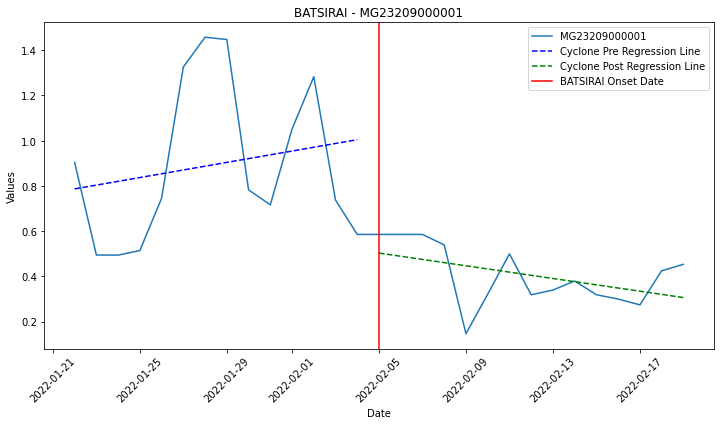

In [5]:
#Key: visualize_cyclone_impact('Cyclone_Name', 'Grid3_Name', lagdays, onset_df, df_date)
visualize_cyclone_impact('BATSIRAI', 'MG23209000001', 14, onset_df, df_date)